In [1]:
# importing dependencies
from datetime import datetime
import os
from pathlib import Path
import pickle
import numpy as np
import qlib
from qlib.config import REG_CN
from qlib.utils import init_instance_by_config
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, SigAnaRecord, PortAnaRecord
from qlib.contrib.model.pytorch_master_ts import MASTERModel
from qlib.contrib.data.dataset import MASTERTSDatasetH
from qlib.contrib.data.handler import Alpha158
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from qlib.utils import exists_qlib_data
from qlib.tests.data import GetData


provider_uri = "~/QuantProject/.qlib/qlib_data/cn_data"  # target_dir
if not exists_qlib_data(provider_uri):
    print(f"Qlib data is not found in {provider_uri}")
    GetData().qlib_data(target_dir=provider_uri, region=REG_CN)
qlib.init(provider_uri=provider_uri, region=REG_CN)

[167925:MainThread](2025-04-07 02:45:15,949) INFO - qlib.Initialization - [config.py:420] - default_conf: client.
[167925:MainThread](2025-04-07 02:45:15,956) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[167925:MainThread](2025-04-07 02:45:15,958) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/home/24039378g/QuantProject/.qlib/qlib_data/cn_data')}


In [4]:
market = "csi300"
benchmark = "SH000300"

data_handler_config = {
    "start_time": "2008-01-01",
    "end_time": "2020-08-01",
    "fit_start_time": "2008-01-01",
    "fit_end_time": "2014-12-31",
    "instruments": market,
    # "filter_pipe": [filter_config],
}

task = {
    "model": {
        "class": "LGBModel",
        "module_path": "qlib.contrib.model.gbdt",
        "kwargs": {
            "loss": "mse",
            "colsample_bytree": 0.8879,
            "learning_rate": 0.0421,
            "subsample": 0.8789,
            "lambda_l1": 205.6999,
            "lambda_l2": 580.9768,
            "max_depth": 8,
            "num_leaves": 210,
            "num_threads": 20,
        },
    },
    "dataset": {
        "class": "DatasetH",
        "module_path": "qlib.data.dataset",
        "kwargs": {
            "handler": {
                "class": "Alpha158",
                "module_path": "qlib.contrib.data.handler",
                "kwargs": data_handler_config,
            },
            "segments": {
                "train": ("2008-01-01", "2014-12-31"),
                "valid": ("2015-01-01", "2016-12-31"),
                "test": ("2017-01-01", "2020-08-01"),
            },
        },
    },
}

dataset = init_instance_by_config(task["dataset"])

data = dataset.prepare("train")  # 检查训练集数据  

[167925:MainThread](2025-04-07 02:47:06,351) INFO - qlib.timer - [log.py:127] - Time cost: 10.160s | Loading data Done
[167925:MainThread](2025-04-07 02:47:07,843) INFO - qlib.timer - [log.py:127] - Time cost: 0.387s | DropnaLabel Done
[167925:MainThread](2025-04-07 02:47:10,191) INFO - qlib.timer - [log.py:127] - Time cost: 2.342s | CSZScoreNorm Done
[167925:MainThread](2025-04-07 02:47:10,195) INFO - qlib.timer - [log.py:127] - Time cost: 3.841s | fit & process data Done
[167925:MainThread](2025-04-07 02:47:10,196) INFO - qlib.timer - [log.py:127] - Time cost: 14.005s | Init data Done


In [ ]:
# preview the data
data.head()
# datetime 表示时间戳，是时间序列数据中的重要字段，用于标记每一条数据的时间点。
# instrument 表示金融工具，是金融数据中的另一个重要字段，用于标识具体的资产或交易品种。

KMID      KLEN     KMID2       KUP      KUP2  \
datetime   instrument                                                     
2008-01-02 SH600000    0.010374  0.061129  0.169699  0.028299  0.462937   
           SH600004    0.057280  0.059661  0.960094  0.002381  0.039906   
           SH600006    0.012673  0.040323  0.314283  0.008065  0.200000   
           SH600007    0.066977  0.084186  0.795580  0.007907  0.093923   
           SH600008    0.051163  0.082326  0.621469  0.027907  0.338982   

                           KLOW     KLOW2      KSFT     KSFT2     OPEN0  ...  \
datetime   instrument                                                    ...   
2008-01-02 SH600000    0.022457  0.367364  0.004531  0.074127  0.989733  ...   
           SH600004    0.000000  0.000000  0.054899  0.920187  0.945823  ...   
           SH600006    0.019585  0.485716  0.024193  0.599999  0.987486  ...   
           SH600007    0.009302  0.110497  0.068372  0.812154  0.937227  ...   
           SH600008    0.003256  0.039549  0.026512  0.322035  0.951327  ...   

                        VSUMN10   VSUMN20   VSUMN30   VSUMN60    VSUMD5  \
datetime   instrument                                                     
2008-01-02 SH600000    0.550639  0.490807  0.485962  0.510337 -0.022349   
           SH600004    0.328894  0.392360  0.423984  0.514932  0.633267   
           SH600006    0.522838  0.433405  0.494553  0.524930 -0.064064   
           SH600007    0.242611  0.291541  0.352613  0.420448  0.878055   
           SH600008    0.425714  0.381852  0.400486  0.469882  0.482783   

                        VSUMD10   VSUMD20   VSUMD30   VSUMD60    LABEL0  
datetime   instrument                                                    
2008-01-02 SH600000   -0.101278  0.018386  0.028076 -0.020675  0.042064  
           SH600004    0.342211  0.215280  0.152031 -0.029863  0.000000  
           SH600006   -0.045677  0.133190  0.010894 -0.049861 -0.008830  
           SH600007    0.514779  0.416918  0.294774  0.159104  0.007495  
           SH600008    0.148572  0.236296  0.199027  0.060235 -0.015446  

[5 rows x 159 columns]

In [6]:
# demonstrating the statistic info
data.describe()

,KMID,KLEN,KMID2,KUP,KUP2,KLOW,KLOW2,KSFT,KSFT2,OPEN0,...,VSUMN10,VSUMN20,VSUMN30,VSUMN60,VSUMD5,VSUMD10,VSUMD20,VSUMD30,VSUMD60,LABEL0
count,482606.000000,482606.000000,482606.000000,482606.000000,482606.000000,482606.000000,482606.000000,482606.000000,482606.000000,482606.000000,...,489685.000000,491390.000000,492575.000000,494764.000000,488130.000000,489685.000000,491390.000000,492575.000000,494764.000000,478007.000000
mean,0.001061,0.038536,0.000153,0.009920,0.273571,0.009324,0.264964,0.000465,-0.008454,0.999661,...,0.510132,0.505881,0.504649,0.503946,-0.036849,-0.020264,-0.011762,-0.009298,-0.007891,0.000149
std,0.026923,0.022913,0.531506,0.009960,0.210284,0.009235,0.204209,0.029233,0.600225,0.026858,...,0.119580,0.073529,0.056845,0.039544,0.406688,0.239159,0.147057,0.113691,0.079087,0.028468
min,-0.179285,0.000000,-1.839999,0.000000,0.000000,-0.025455,-0.839999,-0.377761,-2.679997,0.716954,...,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.239024
25%,-0.013043,0.022348,-0.461553,0.003077,0.101695,0.003157,0.100000,-0.015564,-0.545417,0.985897,...,0.445511,0.469688,0.478513,0.488573,-0.282787,-0.143956,-0.078991,-0.057087,-0.034428,-0.014455
50%,0.000000,0.032524,0.000000,0.007269,0.238806,0.006897,0.226677,0.000000,0.000000,1.000000,...,0.505400,0.502856,0.502272,0.501870,-0.019977,-0.010801,-0.005713,-0.004544,-0.003739,0.000000
75%,0.014305,0.048276,0.456519,0.013699,0.412499,0.012566,0.399891,0.015764,0.520050,1.013216,...,0.571978,0.539496,0.528544,0.517214,0.209738,0.108978,0.060623,0.042974,0.022853,0.014036
max,0.394790,1.241488,1.000000,0.809625,1.000000,0.118519,1.000000,0.223199,1.000000,1.218450,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.279208


In [7]:
# demonstrating the Non-Null Count and type
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 497147 entries, (Timestamp('2008-01-02 00:00:00'), 'SH600000') to (Timestamp('2014-12-31 00:00:00'), 'SZ300251')
Columns: 159 entries, KMID to LABEL0
dtypes: float32(159)
memory usage: 303.5+ MB


In [8]:
# checking null value
data.isna().sum()

KMID       14541
KLEN       14541
KMID2      14541
KUP        14541
KUP2       14541
           ...  
VSUMD10     7462
VSUMD20     5757
VSUMD30     4572
VSUMD60     2383
LABEL0     19140
Length: 159, dtype: int64

In [9]:
# checking duplicate
data.duplicated().sum()

2176

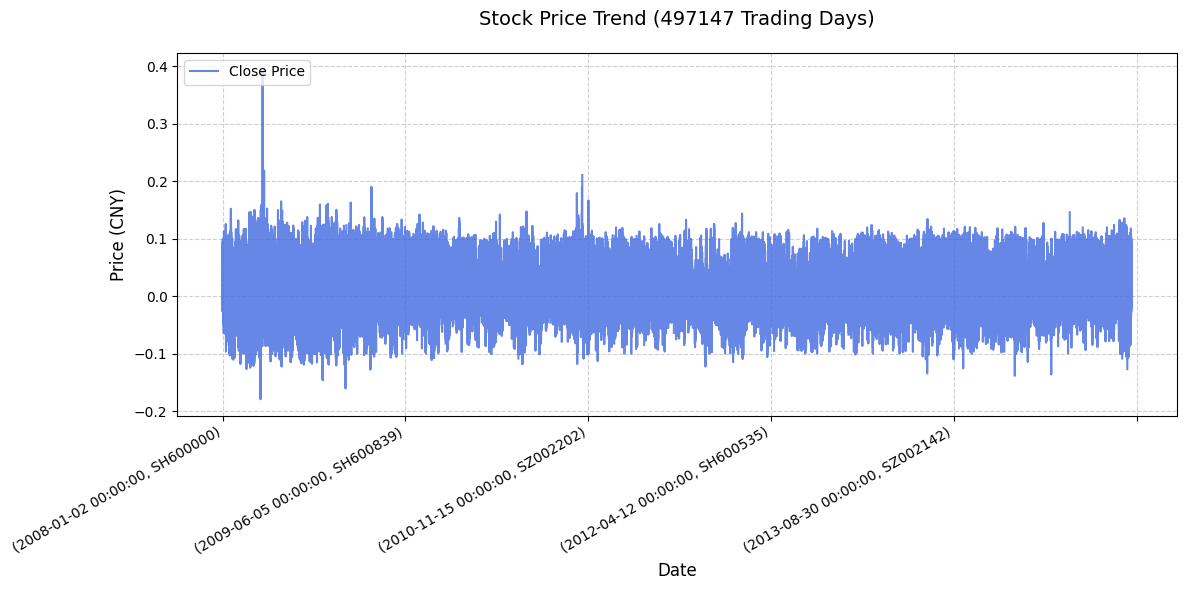

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载数据（确保获取正确的字段）
try:
    data = dataset.prepare("train", col_set=["feature", "label"])
    if isinstance(data, pd.DataFrame) and not data.empty:
        # 假设数据包含日期索引和收盘价字段（根据实际字段名调整）
        close_prices = data["$close"] if "$close" in data.columns else data.iloc[:, 0]  # 备用选择第一列
        
        # 创建画布
        plt.figure(figsize=(12, 6), dpi=100)
        
        # 绘制收盘价曲线
        close_prices.plot(
            linewidth=1.5,
            color="royalblue",
            label="Close Price",
            alpha=0.8
        )
        
        # 图表装饰
        plt.title(f"Stock Price Trend ({len(close_prices)} Trading Days)", 
                 fontsize=14, pad=20)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Price (CNY)", fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.legend(fontsize=10, loc="upper left")
        
        # 自动调整日期显示
        plt.gcf().autofmt_xdate()
        
        # 显示图表
        plt.tight_layout()
        plt.show()
    else:
        print("Warning: Empty DataFrame returned from dataset")
except Exception as e:
    print(f"Error plotting data: {str(e)}")

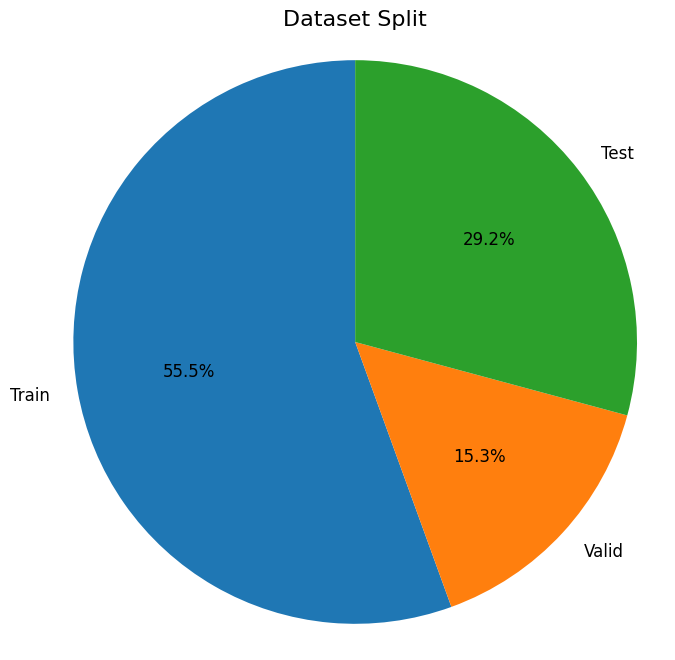

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# 获取训练、验证和测试集数据
train_data = dataset.prepare("train")
valid_data = dataset.prepare("valid")
test_data = dataset.prepare("test")

# 获取数据集样本数量
data_lengths = {
    "train": len(train_data),
    "valid": len(valid_data),
    "test": len(test_data)
}

# 将样本长度数据制作成 DataFrame（非必要，仅用于额外展示）
data_lengths_df = pd.DataFrame(list(data_lengths.items()), columns=['Dataset', 'Samples'])

# 绘制饼图
labels = ['Train', 'Valid', 'Test']  
sizes = [data_lengths['train'], data_lengths['valid'], data_lengths['test']]  # 动态比例

plt.figure(figsize=(8, 8))  # 设置饼图的画布大小
plt.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 12}, startangle=90)
plt.title("Dataset Split", fontsize=16)  # 图标题
plt.axis('equal')  # 保证饼图是圆的
plt.show()

<Figure size 1200x1200 with 0 Axes>

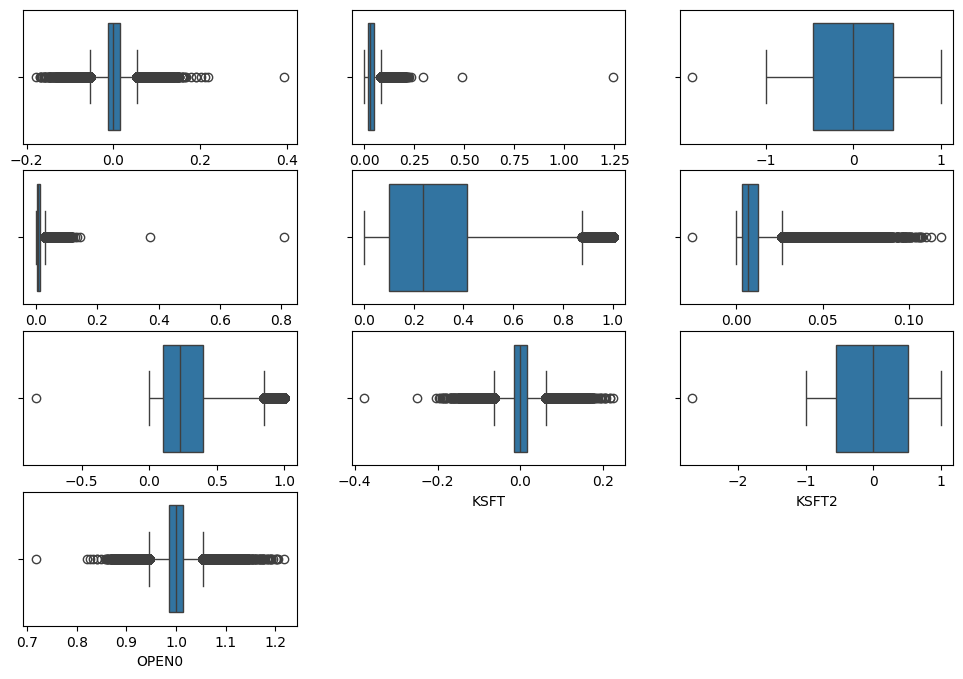

In [15]:
# Adjust the subplot grid size to accommodate all items
all_columns = list(train_data.columns)
columns = all_columns[:10]

plt.figure(figsize=(12, 12))
num_cols = len(columns)
num_rows = (num_cols // 3) + (num_cols % 3 > 0)  # Calculate the number of rows needed
plt.figure(figsize=(12, 4 * num_rows))  # Adjust figure height based on number of rows
for i, col in enumerate(columns):
    plt.subplot(num_rows, 3, i + 1)  # Adjust subplot indexing
    sns.boxplot(x=col, data=data)
plt.show()

In [16]:
# sns.pairplot(data = data, hue = 'x')
# plt.show()

<Figure size 1200x1200 with 0 Axes>

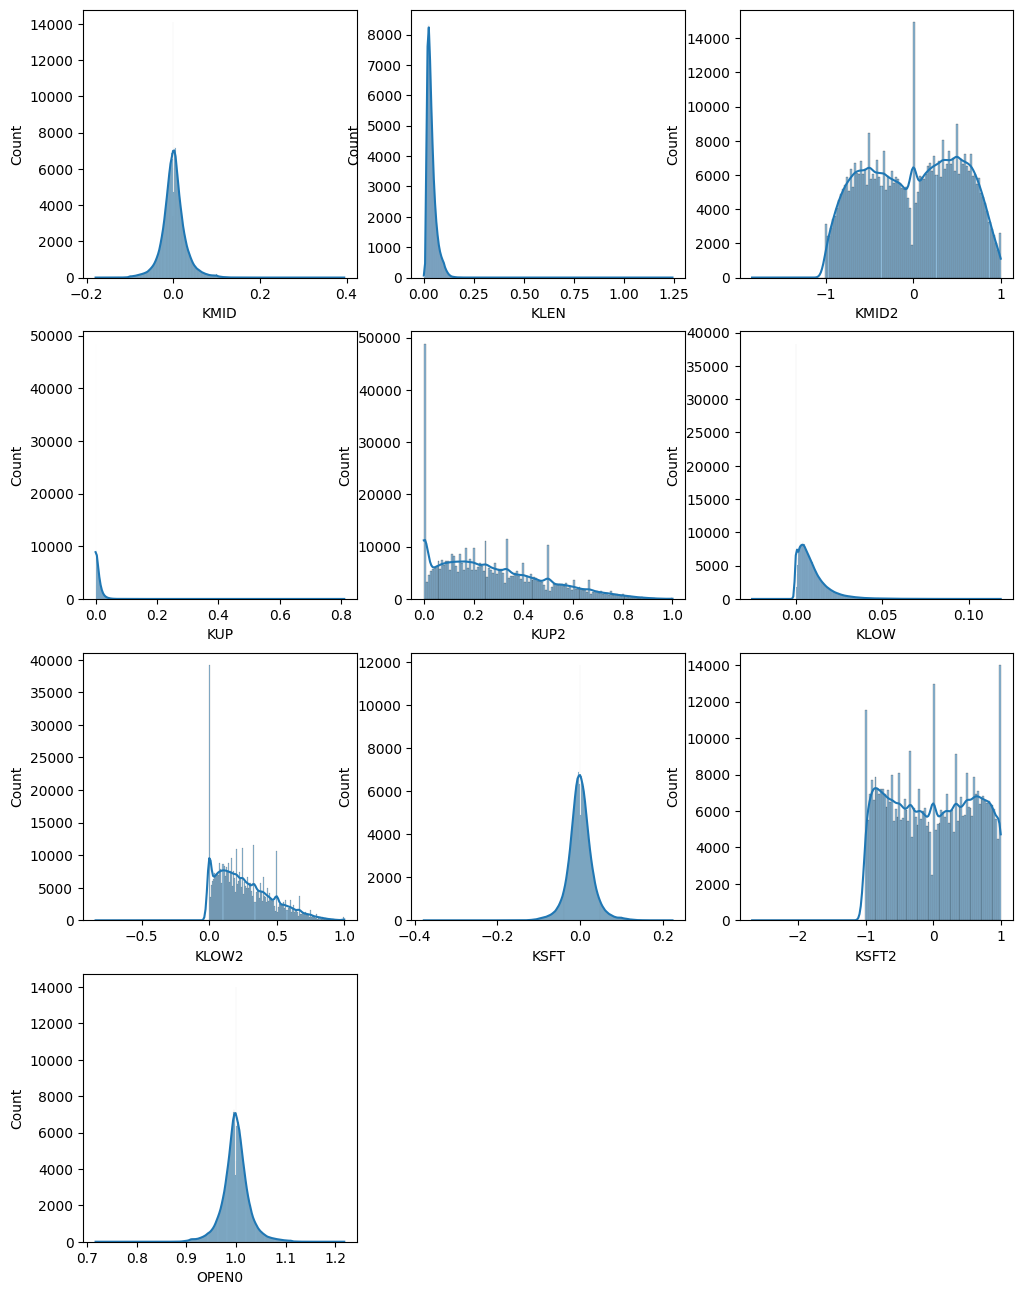

In [16]:
# Adjust the subplot grid size to accommodate all items
plt.figure(figsize=(12, 12))
num_cols = len(columns)
num_rows = (num_cols // 3) + (num_cols % 3 > 0)  # Calculate the number of rows needed
plt.figure(figsize=(12, 4 * num_rows))  # Adjust figure height based on number of rows
for i, col in enumerate(columns):
    plt.subplot(num_rows, 3, i + 1)  # Adjust subplot indexing
    sns.histplot(x=col, data=data, kde=True)
plt.show()

# The Heatmap

In [ ]:
# Step 1: Drop unnecessary columns
nd = data.drop([
], axis=1)

# Step 2: Add new columns for Label = 0, 1, 2, 3
nd["none"] = (nd["Label"] == 0).astype(int)  # Label == 0
nd["left"] = (nd["Label"] == 1).astype(int)  # Label == 1
nd["right"] = (nd["Label"] == 2).astype(int)  # Label == 2
nd["both"] = (nd["Label"] == 3).astype(int)  # Label == 3

# Step 3: Filter only numerical data
numerical_data = nd.select_dtypes(include=["number"])

# Step 4: Calculate the correlation matrix
correlation_matrix = numerical_data.corr()

# Step 5: Plot the heatmap
plt.figure(figsize=(50, 50))  # Adjust the figure size as needed
sns.heatmap(data=correlation_matrix, vmin=-1.0, center=0, cmap='RdBu_r', annot=True)
plt.title("Heatmap of Correlation Matrix")
plt.show()

Standard Scaling and Label Encoding

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

# 数据预处理：标准化与缺失值处理
scaler = StandardScaler()

numerical_data = data.select_dtypes(include=["number"])
X = numerical_data.drop(["Label", "Polyp Left Length Ratio", "Polyp Right Length Ratio"], axis = 1)
X = X.dropna(axis=1)
y = data["Label"]

f_values, p_values = f_classif(X, y)
f_stat_df = pd.DataFrame({
    "Feature": X.columns,
    "F-Value": f_values,
    "P-Value": p_values
})

# Step 5: Sort features by F-value
f_stat_df = f_stat_df.sort_values(by="F-Value", ascending=False)

# Print the F-values DataFrame
print(f_stat_df)

X_normalized = scaler.fit_transform(X)
X_imputed = SimpleImputer(strategy='median').fit_transform(X_normalized)

# ANOVA初筛（选择F值最高的前20个特征）
selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X_imputed, y)

# 输出筛选结果
selected_features = X.columns[selector.get_support()]
print("ANOVA筛选特征: ", selected_features)

               Feature    F-Value       P-Value
36   right_MFCC_1_mean  32.304409  7.685320e-20
3     left_shimmer_rel  28.625242  1.094737e-17
34   right_shimmer_rel  28.625242  1.094737e-17
40   right_MFCC_3_mean  24.709507  2.261758e-15
38   right_MFCC_2_mean  15.680914  5.996774e-10
..                 ...        ...           ...
50   right_MFCC_8_mean   0.655507  5.796042e-01
11    left_MFCC_4_mean   0.545962  6.509601e-01
15    left_MFCC_6_mean   0.488682  6.902167e-01
52   right_MFCC_9_mean   0.420486  7.383482e-01
56  right_MFCC_11_mean   0.292568  8.307908e-01

[64 rows x 3 columns]
ANOVA筛选特征:  Index(['Gender', 'Age', 'left_shimmer_dB', 'left_shimmer_rel', 'left_hnr',
       'left_MFCC_1_mean', 'left_MFCC_1_std', 'left_MFCC_2_mean',
       'left_MFCC_2_std', 'left_MFCC_3_mean', 'left_MFCC_3_std',
       'left_MFCC_4_mean', 'left_MFCC_4_std', 'left_MFCC_5_mean',
       'left_MFCC_5_std', 'left_MFCC_6_mean', 'left_MFCC_6_std',
       'left_MFCC_7_mean', 'left_MFCC_7_std', 'left_

In [22]:
# Ensure first dimension (number of features) matches
# train_features = vif_selected_features
train_features = selected_features

X_normalized_data = X_normalized[:, :len(train_features)]  # Select the first columns equal to the length of selected_features

X_df = pd.DataFrame(data=X_normalized_data, columns = train_features)
X_df.head()

,Gender,Age,left_shimmer_dB,left_shimmer_rel,left_hnr,left_MFCC_1_mean,left_MFCC_1_std,left_MFCC_2_mean,left_MFCC_2_std,left_MFCC_3_mean,...,right_MFCC_10_mean,right_MFCC_10_std,right_MFCC_11_mean,right_MFCC_11_std,right_MFCC_12_mean,right_MFCC_12_std,right_MFCC_13_mean,right_MFCC_13_std,right_delta_mean,right_delta_delta_delta_mean
0,-0.960092,0.852406,-0.775135,0.900903,0.746130,0.641908,0.155125,0.910827,1.179978,1.054786,...,0.503462,-0.686904,0.347955,-0.373028,0.693291,-0.101037,0.427155,0.594385,0.124038,-0.933421
1,-0.960092,-1.800853,-0.565307,0.799797,-0.344075,1.131376,0.534019,0.697565,1.622213,1.305874,...,-1.322107,0.943712,0.188196,0.686812,-0.056416,1.564435,-0.855738,0.826109,0.635696,1.874105
2,-0.960092,-1.030552,-1.929387,1.648516,1.040431,1.001900,0.416752,0.636178,0.648237,2.097483,...,-0.279589,-0.433372,-0.607623,0.123093,-0.039946,0.798981,-0.369307,0.505002,-0.241288,-0.782310
3,1.041567,0.338872,-1.198323,1.209965,0.003804,0.768208,0.685744,0.420652,2.441896,2.346390,...,0.333623,-1.062981,0.575433,-1.327479,0.022233,-1.299721,0.326005,-1.907564,1.959073,-0.250202
4,1.041567,-1.116141,-1.149943,1.032020,1.091120,0.876645,-0.601578,0.214224,-0.809952,0.753837,...,-1.129204,-1.213225,-0.553990,-1.435432,-0.347510,-1.101667,-0.792182,-0.728507,-0.195541,0.755259


In [23]:
# importing train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size = 0.3, random_state = 0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# 1. 训练随机森林模型并计算特征重要性
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 获取特征重要性
importance = pd.DataFrame({
    "Feature": X_train.columns, 
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("Feature Importances:", importance)

# 2. 设定阈值，筛选出重要性较高的特征
threshold = 0.021  # 定义阈值，例如0.01
selected_features = importance[importance["Importance"] > threshold]["Feature"]
print(f"Selected Features (Importance > {threshold}):", selected_features)

# 仅保留高于阈值的特征进行训练和测试
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# 3. 用筛选后的特征重新训练模型
model_selected = RandomForestClassifier(random_state=42)
model_selected.fit(X_train_selected, y_train)

# 计算使用筛选后特征的模型准确率
accuracy = model_selected.score(X_test_selected, y_test)
print(f"RandomForestClassifier Accuracy (with selected features): {accuracy}")


Feature Importances:                Feature  Importance
36   right_MFCC_1_mean    0.022271
5     left_MFCC_1_mean    0.020044
1                  Age    0.019367
14     left_MFCC_5_std    0.018996
56  right_MFCC_11_mean    0.018277
..                 ...         ...
12     left_MFCC_4_std    0.013453
24    left_MFCC_10_std    0.012942
51    right_MFCC_8_std    0.012194
28    left_MFCC_12_std    0.012142
0               Gender    0.003525

[64 rows x 2 columns]
Selected Features (Importance > 0.021): 36    right_MFCC_1_mean
Name: Feature, dtype: object
RandomForestClassifier Accuracy (with selected features): 0.326007326007326


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l2', C=1.0)
model.fit(X_train, y_train)
print("Ridge-Regularized Logistic Regression Accuracy: ", model.score(X_test, y_test))

Ridge-Regularized Logistic Regression Accuracy:  0.3443223443223443


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Preprocess Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Define GPR Kernel
kernel = ConstantKernel(1.0, constant_value_bounds=(0.1, 10)) * \
         RBF(1.0, length_scale_bounds=(0.1, 10.0)) + \
         WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e1))

# Step 3: Train GPR Model
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True)
gpr.fit(X_train_scaled, y_train)

# Step 4: Make Predictions
y_pred, y_std = gpr.predict(X_test_scaled, return_std=True)

# Step 5: Post-Processing for Classification
# Round predictions to nearest integer and clip to valid range [0, 1, 2, 3]
y_pred_class = y_pred.round().clip(0, 3).astype(int)

# Step 6: Evaluate Classification Accuracy
accuracy = accuracy_score(y_test, y_pred_class)
print(f"Classification Accuracy: {accuracy:.2f}")

# Optional: Generate a Detailed Classification Report
print(classification_report(y_test, y_pred_class))

Classification Accuracy: 0.34
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        26
         1.0       0.00      0.00      0.00        86
         2.0       0.34      1.00      0.51        94
         3.0       0.00      0.00      0.00        67

    accuracy                           0.34       273
   macro avg       0.09      0.25      0.13       273
weighted avg       0.12      0.34      0.18       273



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

# KNN Operation

In [24]:
from sklearn.neighbors import KNeighborsClassifier

test_scores = []
train_scores = []

for i in range(1, 15):
    knn = KNeighborsClassifier(i)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))

In [25]:
max_train_score = max(train_scores)
train_scores_index = [i for i, v in enumerate(train_scores) if v == max_train_score]
print("Max Train score {}% and k = {}".format(max_train_score*100, list(map(lambda x: x+1, train_scores_index))))

Max Train score 100.0% and k = [1]


In [26]:
max_test_score = max(test_scores)
test_scores_index = [i for i, v in enumerate(test_scores) if v == max_test_score]
print("Max Test score {}% and k = {}".format(max_test_score*100, list(map(lambda x: x+1, test_scores_index))))

Max Test score 35.53113553113553% and k = [12, 13]


In [27]:
knn = KNeighborsClassifier(13)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.3553113553113553

In [28]:
from sklearn.metrics import confusion_matrix
y_pred = knn.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 2, 11, 11,  2],
       [ 4, 44, 26, 12],
       [ 0, 48, 43,  3],
       [ 0, 33, 26,  8]], dtype=int64)

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.33      0.08      0.12        26
         1.0       0.32      0.51      0.40        86
         2.0       0.41      0.46      0.43        94
         3.0       0.32      0.12      0.17        67

    accuracy                           0.36       273
   macro avg       0.35      0.29      0.28       273
weighted avg       0.35      0.36      0.33       273

